# SYDE556/750 Assignment 4: Nengo and Dynamics

- Due Date: March 14th (midnight)
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day

- For this assignment, you must use Nengo, which can be downloaded from http://github.com/nengo/nengo.  Instructions for installing are [here](https://github.com/nengo/nengo/blob/master/README.rst).
    - Feel free to look through the examples folder before doing this assignment.
- You can also use Nengo GUI if you'd like: https://github.com/nengo/nengo_gui

In [2]:
%pylab inline

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 18

import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform
from nengo.solvers import LstsqNoise

Populating the interactive namespace from numpy and matplotlib


## 1) Building an ensemble of neurons

Make a new model and inside that model make an ensemble of neurons.  It should have 100 neurons, and represent a 1-dimensional space.  The intercepts should be between -1 and 1, and the maximum firing rates should be between 100Hz and 200Hz.  $\tau_{RC}$ should be 0.02s and $\tau_{ref}$ should be 0.002s.

[1 mark] Plot the tuning curves. Plot and the representation accuracy plot ($x$ and $\hat{x}$ on the same plot).  Compute and report the RMSE.

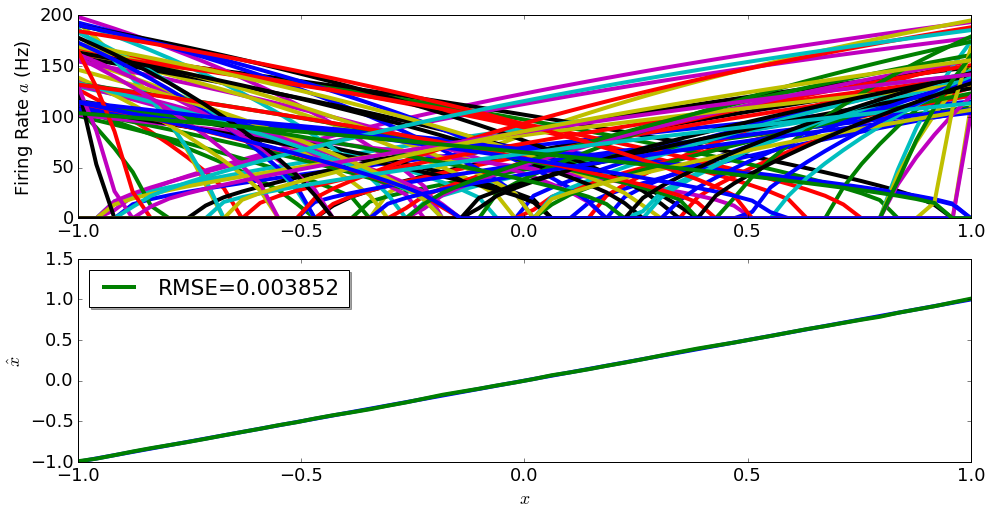

In [20]:
def one_a():

	#ensemble parameters
	N=100
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	noise=0.1
	lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_ref)

	#model definition
	model = nengo.Network(label='1D Ensemble of LIF Neurons')
	with model:
		ens_1d = nengo.Ensemble(N,dimensions,
								intercepts=Uniform(-1.0,1.0),
								max_rates=Uniform(100,200),
								neuron_type=lif_model)

		#generate the decoders
		connection = nengo.Connection(ens_1d,ens_1d,
								solver=LstsqNoise(noise=noise))

	#create the simulator
	sim = nengo.Simulator(model)

	#retrieve evaluation points, activities, and decoders
	eval_points, activities = tuning_curves(ens_1d,sim)
	decoders = sim.data[connection].decoders.T

	#calculate the state estimate
	xhat = np.dot(activities,decoders)

	#plot tuning curves
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(211)
	ax.plot(eval_points,activities)
	# ax.set_xlabel('$x$')
	ax.set_ylabel('Firing Rate $a$ (Hz)')

	#plot representational accuracy
	ax=fig.add_subplot(212)
	ax.plot(eval_points,eval_points)
	ax.plot(eval_points,xhat,
		label='RMSE=%f' %np.sqrt(np.average((eval_points-xhat)**2)))
	ax.set_xlabel('$x$')
	ax.set_ylabel('$\hat{x}$')
	legend=ax.legend(loc='best',shadow=True)
	plt.show()
    
one_a()

[1 mark] What happens to the RMSE as the radius increases?  Why?  Provide four example points (i.e., RMSE at various radiuses).  (Note: Nengo will automatically rescale the intercepts as the radius increases, but plot tuning curves in a normalized range.)

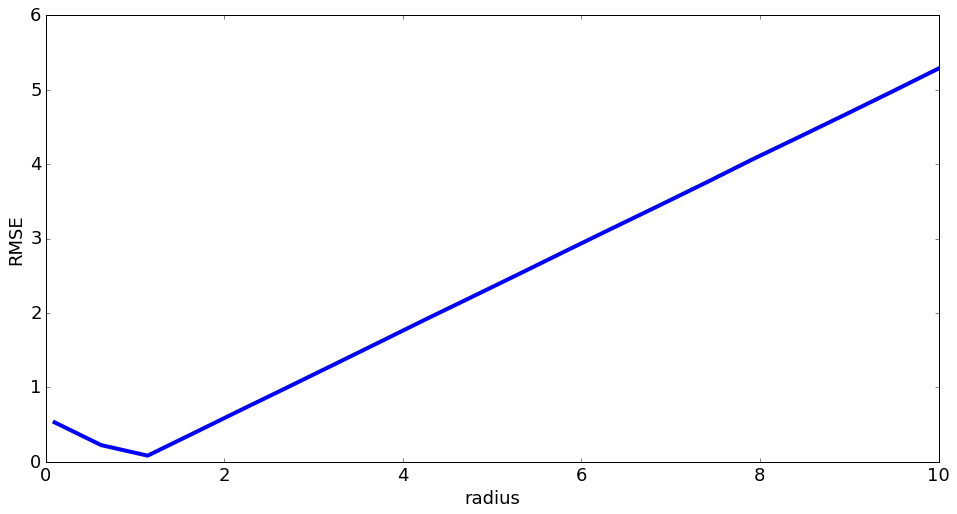

In [21]:
def one_b():

	#ensemble parameters
	N=100
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	noise=0.1
	averages=5
	seed=3

	#objects and lists
	radii=np.linspace(0.1,10,20)
	RMSE_list=[]
	RMSE_stddev_list=[]

	for i in range(len(radii)):

		RMSE_list_i=[]
		for a in range(averages):

			seed=3+a+i*len(radii)
			rng1=np.random.RandomState(seed=seed)
			lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_ref)

			#model definition
			model = nengo.Network(label='1D LIF Ensemble',seed=seed)
			with model:
				ens_1d = nengo.Ensemble(N,dimensions,
										intercepts=Uniform(-1.0,1.0),
										max_rates=Uniform(100,200),
										radius=radii[i],
										#encoders=encoders,
										neuron_type=lif_model)

				#generate the decoders
				connection = nengo.Connection(ens_1d,ens_1d,
										solver=LstsqNoise(noise=noise))

			#create the simulator
			sim = nengo.Simulator(model)

			#retrieve evaluation points, activities, and decoders
			eval_points, activities = tuning_curves(ens_1d,sim)
			decoders = sim.data[connection].decoders.T

			#calculate the state estimate
			xhat = np.dot(activities,decoders)

			#calculate RMSE
			RMSE_list_i.append(np.sqrt(np.average((eval_points-xhat)**2)))

		RMSE_list.append(np.average(RMSE_list_i))
		RMSE_stddev_list.append(np.std(RMSE_list_i))

	#plot RMSE vs radius
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(radii,RMSE_list)
	ax.fill_between(radii,
		np.subtract(RMSE_list,RMSE_stddev_list),np.add(RMSE_list,RMSE_stddev_list),
		color='lightgray') #error is too small to see here
	ax.set_xlabel('radius')
	ax.set_ylabel('RMSE')
	plt.show()
        
one_b()

RMSE increases linearly with radius, a parameter which specifies the interval (-radius,radius) spanned by the evaluation points when calculating the decoders. As radius increases, the neurons must cover a larger area of state space: a fixed number of neurons will represent this space with greater error. The reason is not immediately obvious, because nengo.Ensemble() calculates the $\alpha$s and $J^{bias}$s for each neuron in the ensemble based on the radius of the space to be represented. It distributes them across the space, with a fixed number of evaluation points, so the size of the space is irrelevant for the tuning curve shape. However, the larger scale of the axis means that any deviations between the decoded value and the original value, $x - \hat{x}$, at the evaluation points will also be scaled, increasing the RMSE. 

[0.5 marks] What happens to the RMSE and the tuning curves as $\tau_{ref}$ changes?  Why?

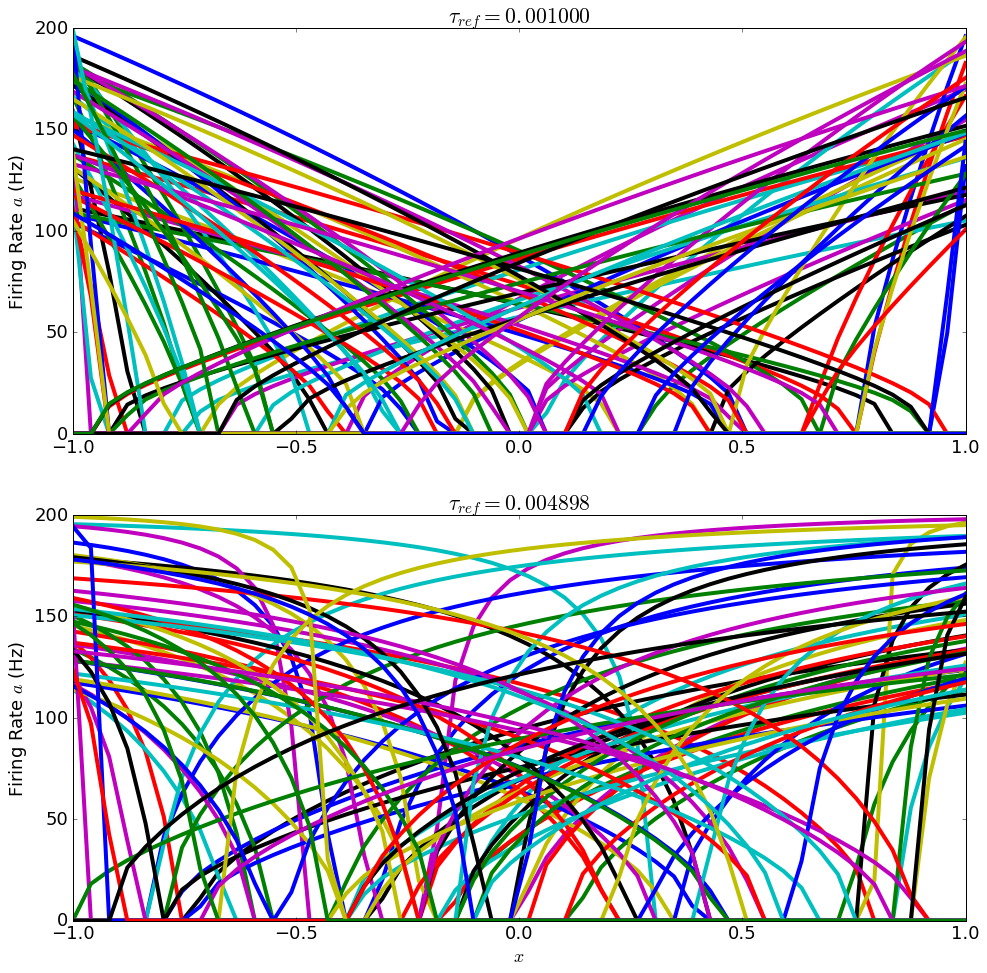

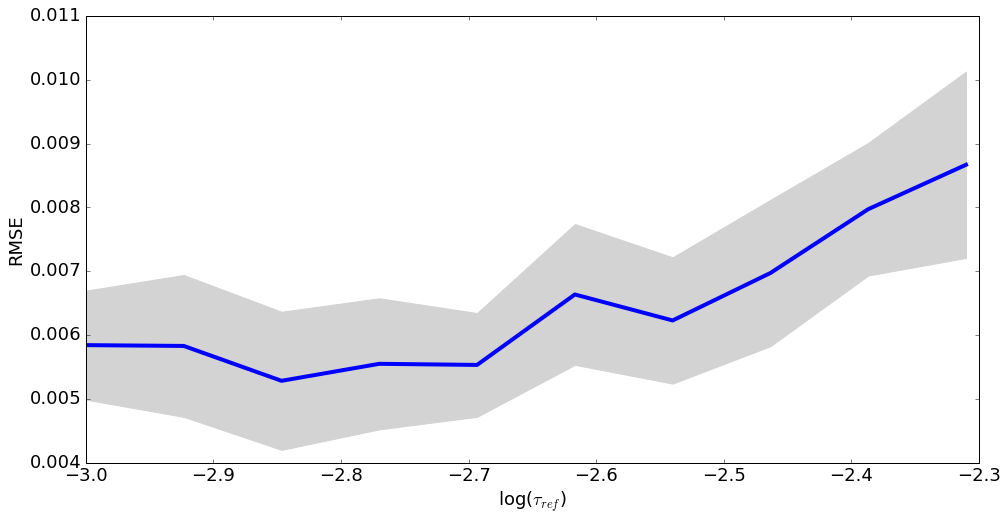

In [22]:
def one_c():

	#ensemble parameters
	N=100
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	noise=0.1
	averages=10
	seed=3

	#objects and lists
	tau_refs=np.logspace(-3,-2.31,10)
	# tau_refs=np.linspace(0.0002,0.0049,10)
	RMSE_list=[]
	RMSE_stddev_list=[]
	eval_points_list=[]
	activities_list=[]

	for i in range(len(tau_refs)):

		RMSE_list_i=[]
		for a in range(averages):

			seed=3+a+i*len(tau_refs) #unique seed for each iteration
			rng1=np.random.RandomState(seed=seed)
			lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_refs[i])

			#model definition
			model = nengo.Network(label='1D LIF Ensemble',seed=seed)
			with model:
				ens_1d = nengo.Ensemble(N,dimensions,
										intercepts=Uniform(-1.0,1.0),
										max_rates=Uniform(100,200),
										neuron_type=lif_model)

				#generate the decoders
				connection = nengo.Connection(ens_1d,ens_1d,
										solver=LstsqNoise(noise=noise))

			#create the simulator
			sim = nengo.Simulator(model)

			#retrieve evaluation points, activities, and decoders
			eval_points, activities = tuning_curves(ens_1d,sim)
			eval_points_list.append(eval_points)
			activities_list.append(activities)
			decoders = sim.data[connection].decoders.T

			#calculate the state estimate
			xhat = np.dot(activities,decoders)

			#calculate RMSE
			RMSE_list_i.append(np.sqrt(np.average((eval_points-xhat)**2)))

		RMSE_list.append(np.average(RMSE_list_i))
		RMSE_stddev_list.append(np.std(RMSE_list_i))

	# plot tuning curves
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.plot(eval_points_list[0],activities_list[0])
	ax.set_title('$\\tau_{ref}=%f$' %tau_refs[0])
	# ax.set_xlabel('$x$')
	ax.set_ylabel('Firing Rate $a$ (Hz)')
	ax=fig.add_subplot(212)
	ax.plot(eval_points_list[-1],activities_list[-1])
	ax.set_title('$\\tau_{ref}=%f$' %tau_refs[-1])
	ax.set_xlabel('$x$')
	ax.set_ylabel('Firing Rate $a$ (Hz)')
	plt.show()

	#plot RMSE vs radius
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(np.log10(tau_refs),RMSE_list)
	ax.fill_between(np.log10(tau_refs),
		np.subtract(RMSE_list,RMSE_stddev_list),np.add(RMSE_list,RMSE_stddev_list),
		color='lightgray')
	ax.set_xlabel('log($\\tau_{ref}$)')
	ax.set_ylabel('RMSE')
	plt.show()
    
one_c()

The neurons' tunning curves change shape as expected given Figure 4.3 in the NEF book (small $\tau_{ref}$ causes a continuous change in firing in response to changes in stimulus value, while large $\tau_{ref}$ causes a discontinuous change). The result that increasing $\tau_{ref}$ increases RMSE can be understood in reference to the function we are trying to represent, $y=x$. Because this function is linear, its value changes continuously with stimulus magnitude. The best representation of this function will result from neurons whose firing rates change continuously with stimulus magnitude, as is the case with small $\tau_{ref}$. If we wanted to represent a function which changed sharply with stimulus value (such as a step function), a more discontinuous tuning curve would be the better choice, and large $\tau_{ref}$ would be most appropriate.

[0.5 marks] What happens to the RMSE and the tuning curves as $\tau_{RC}$ changes?  Why?

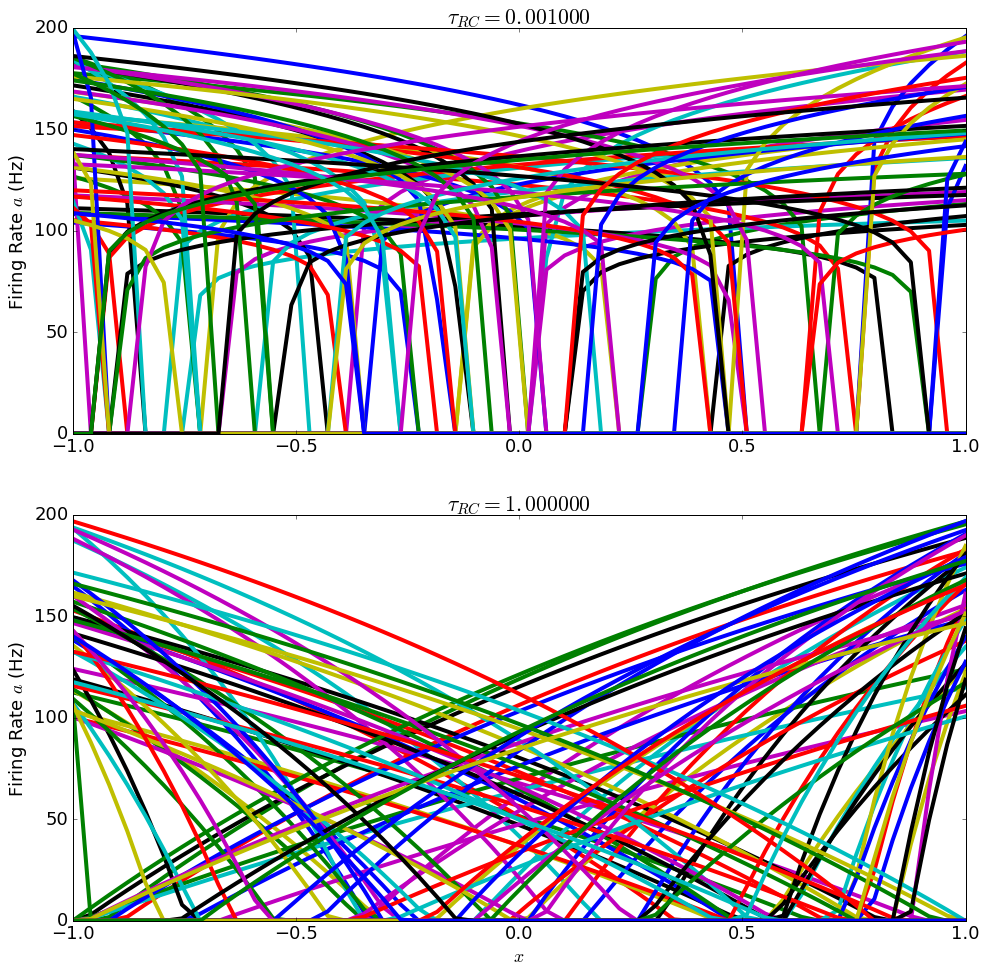

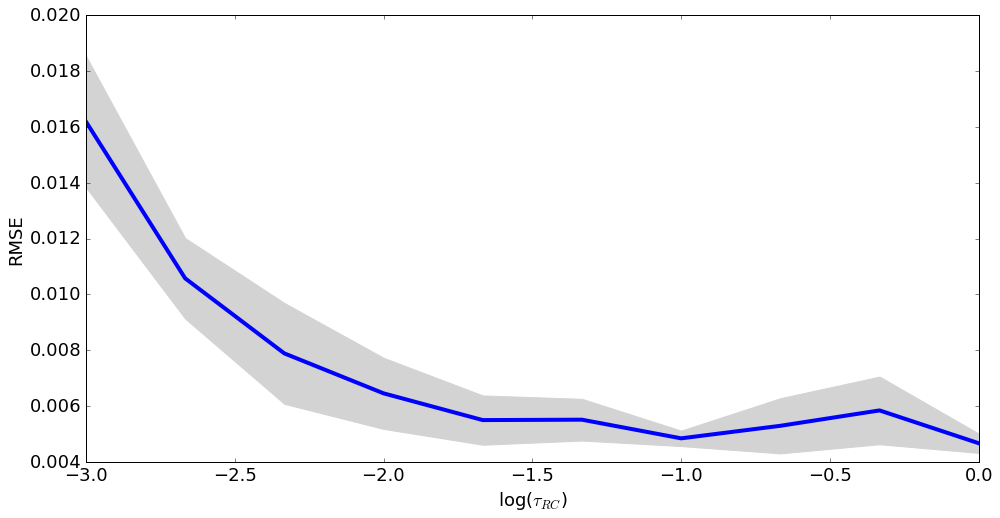

In [23]:
def one_d():

	#ensemble parameters
	N=100
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	noise=0.1
	averages=5
	seed=3

	#objects and lists
	tau_rcs=np.logspace(-3,0,10)
	RMSE_list=[]
	RMSE_stddev_list=[]
	eval_points_list=[]
	activities_list=[]

	for i in range(len(tau_rcs)):

		RMSE_list_i=[]
		for a in range(averages):

			seed=3+a+i*len(tau_rcs) #unique seed for each iteration
			rng1=np.random.RandomState(seed=seed)
			lif_model=nengo.LIF(tau_rc=tau_rcs[i],tau_ref=tau_ref)

			#model definition
			model = nengo.Network(label='1D LIF Ensemble',seed=seed)
			with model:
				ens_1d = nengo.Ensemble(N,dimensions,
										intercepts=Uniform(-1.0,1.0),
										max_rates=Uniform(100,200),
										neuron_type=lif_model)

				#generate the decoders
				connection = nengo.Connection(ens_1d,ens_1d,
										solver=LstsqNoise(noise=noise))

			#create the simulator
			sim = nengo.Simulator(model)

			#retrieve evaluation points, activities, and decoders
			eval_points, activities = tuning_curves(ens_1d,sim)
			eval_points_list.append(eval_points)
			activities_list.append(activities)
			decoders = sim.data[connection].decoders.T

			#calculate the state estimate
			xhat = np.dot(activities,decoders)

			#calculate RMSE
			RMSE_list_i.append(np.sqrt(np.average((eval_points-xhat)**2)))

		RMSE_list.append(np.average(RMSE_list_i))
		RMSE_stddev_list.append(np.std(RMSE_list_i))

	# plot tuning curves
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.plot(eval_points_list[0],activities_list[0])
	ax.set_title('$\\tau_{RC}=%f$' %tau_rcs[0])
	# ax.set_xlabel('$x$')
	ax.set_ylabel('Firing Rate $a$ (Hz)')
	ax=fig.add_subplot(212)
	ax.plot(eval_points_list[-1],activities_list[-1])
	ax.set_title('$\\tau_{RC}=%f$' %tau_rcs[-1])
	ax.set_xlabel('$x$')
	ax.set_ylabel('Firing Rate $a$ (Hz)')
	plt.show()

	#plot RMSE vs radius
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(np.log10(tau_rcs),RMSE_list)
	ax.fill_between(np.log10(tau_rcs),
		np.subtract(RMSE_list,RMSE_stddev_list),np.add(RMSE_list,RMSE_stddev_list),
		color='lightgray')
	# ax.plot(tau_refs,RMSE_list)
	ax.set_xlabel('log($\\tau_{RC}$)')
	ax.set_ylabel('RMSE')
	plt.show()
    
one_d()

The neurons' tunning curves change shape as expected given Figure 4.3 in the NEF book (large $\tau_{RC}$ causes a continuous change in firing in response to changes in stimulus value, while small $\tau_{RC}$ causes a discontinuous change). The result that increasing $\tau_{RC}$ decreases RMSE can be understood in reference to the function we are trying to represent, $y=x$. Because this function is linear, its value changes continuously with stimulus magnitude. The best representation of this function will result from neurons whose firing rates change continuously with stimulus magnitude, as is the case with large $\tau_{RC}$. If we wanted to represent a function which changed sharply with stimulus value (such as a step function), a more discontinuous tuning curve would be the better choice, and small $\tau_{RC}$ would be most appropriate.

## 2) Connecting neurons

Make a second ensemble of neurons.  It should have the same parameters as the first ensemble of neurons (from the first question), but have only 50 neurons in it.  Connect the first ensemble to the second such that it computes the identity function, using a post-synaptic time constant of 0.01.  Create an input that is a value of 1 for $0.1<t<0.4$ seconds, and otherwise is zero (you can use a lambda function).

In [25]:
def two_template(channel_function):

	#ensemble parameters
	N=50
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	noise=0.1
	T=0.5
	seed=3

	lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_ref)

	model=nengo.Network(label='Communication Channel')

	with model:
		#stimulus 1 for 0.1<t<0.4 and zero otherwise
		stimulus=nengo.Node(output=lambda t: 0+ 1.0*(0.1<t<0.4))

		#create ensembles
		ensemble_1=nengo.Ensemble(N,dimensions,
									intercepts=Uniform(-1.0,1.0),
									max_rates=Uniform(100,200),
									neuron_type=lif_model)
		ensemble_2=nengo.Ensemble(N,dimensions,
									intercepts=Uniform(-1.0,1.0),
									max_rates=Uniform(100,200),
									neuron_type=lif_model)

		#connect stimulus to ensemble_1
		stimulation=nengo.Connection(stimulus,ensemble_1)

		#create communication channel between ensemble 1 and 2
		channel=nengo.Connection(ensemble_1,ensemble_2,
									function=channel_function, #identity
									synapse=0.01,  #10ms postsynaptic filter
									solver=LstsqNoise(noise=noise))

		#calculate the 
		#probe the decoded values from the two ensembles
		probe_stim=nengo.Probe(stimulus)
		probe_ensemble_1=nengo.Probe(ensemble_1, synapse=0.01)
		probe_ensemble_2=nengo.Probe(ensemble_2, synapse=0.01)

	#run the model
	sim=nengo.Simulator(model,seed=seed)
	sim.run(T)

	#plot inputs and outputs
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(221)
	ax.plot(sim.trange(),sim.data[probe_stim],label='stimulus')
	ax.set_xlabel('time (s)')
	ax.set_ylabel('output')
	# ax.set_ylim(0,1)
	legend=ax.legend(loc='upper right',shadow=True)
	ax=fig.add_subplot(222)
	ax.plot(sim.trange(),sim.data[probe_ensemble_1],label='ensemble 1')
	ax.set_xlabel('time (s)')
	ax.set_ylabel('output')
	# ax.set_ylim(0,1)
	legend=ax.legend(loc='upper right',shadow=True)
	ax=fig.add_subplot(223)
	ax.plot(sim.trange(),sim.data[probe_ensemble_2],label='ensemble 2')
	ax.set_xlabel('time (s)')
	ax.set_ylabel('output')
	# ax.set_ylim(0,1)
	legend=ax.legend(loc='upper right',shadow=True)
	plt.tight_layout()
	plt.show()

[1 mark] Show the input value and the decoded values from the two ensembles in three separate plots.  Run the simulation for 0.5 seconds.

Simulation finished in 0:00:01.                                                 


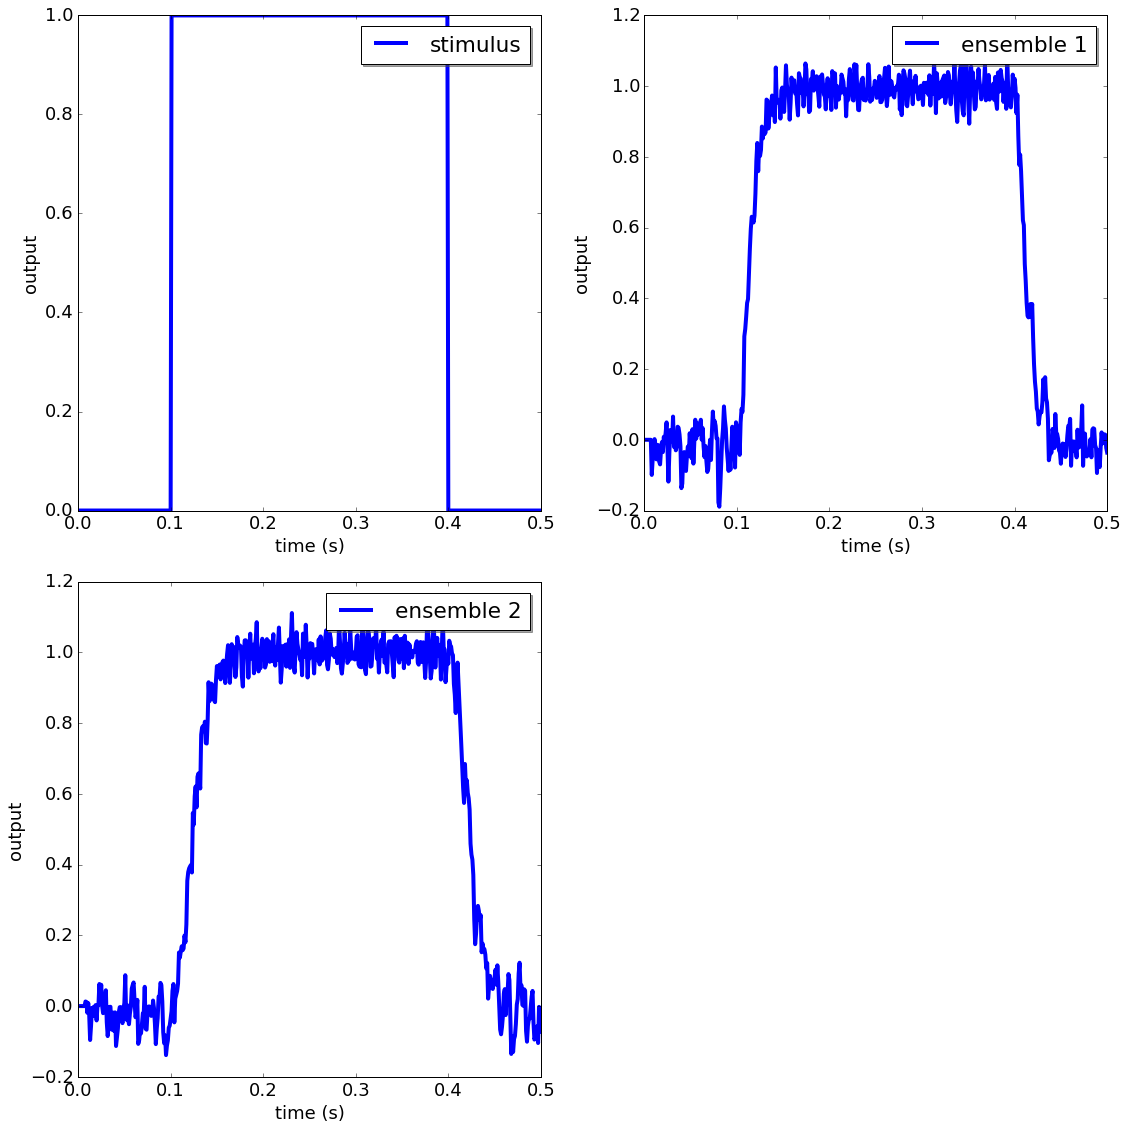

In [26]:
def two_a():

	channel_function = lambda x: x
	two_template(channel_function)
    
two_a()

[1 mark] Make a new version of the model where instead of computing the identity function, it computes `y=1-2*x`.  Show the same graphs as in part (a).

Simulation finished in 0:00:01.                                                 


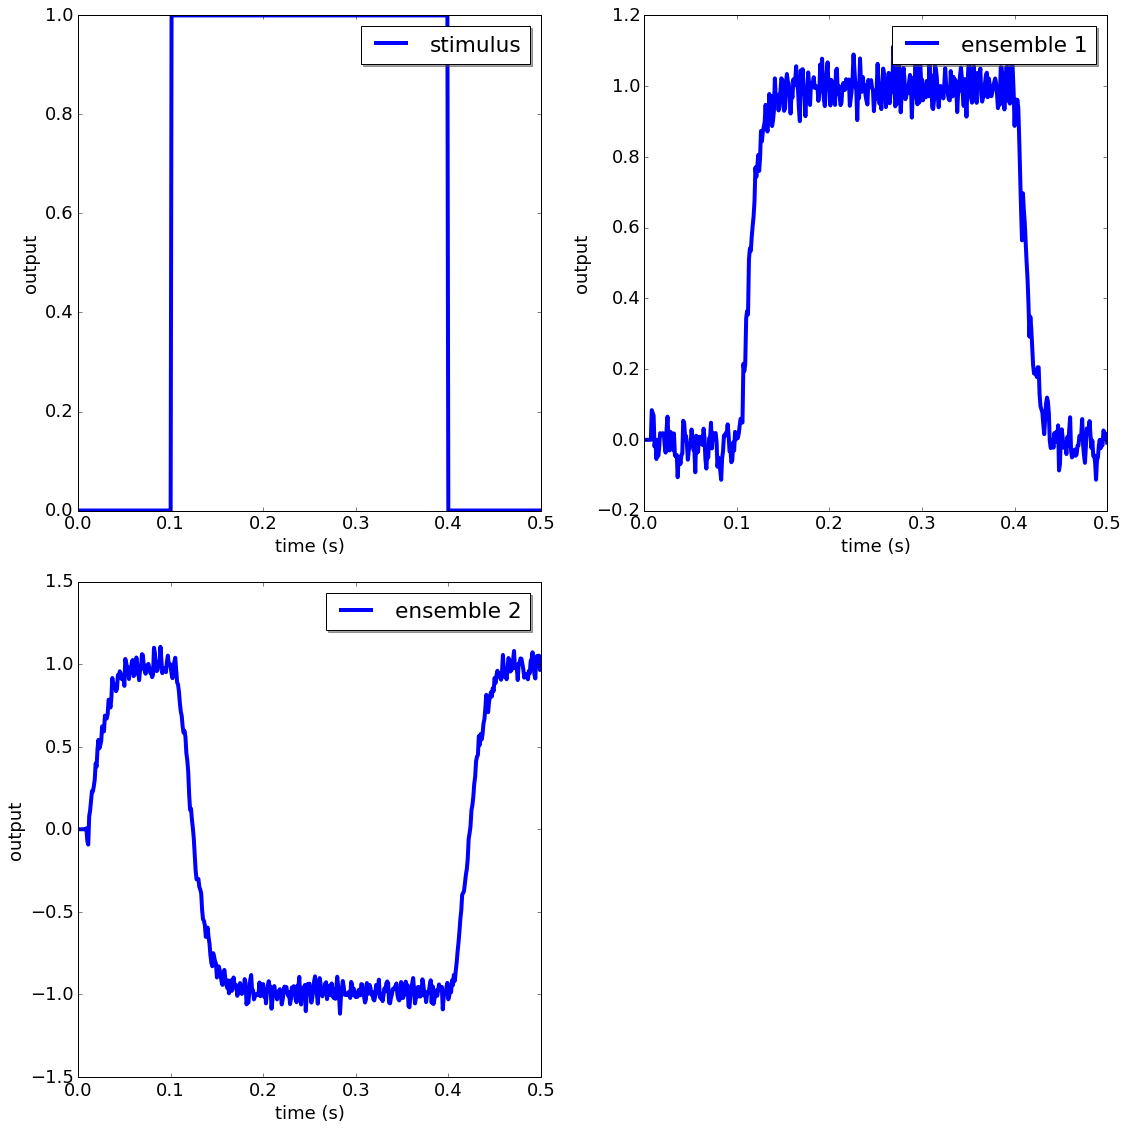

In [27]:
def two_b():

	channel_function = lambda x: 1.0-2.0*x
	two_template(channel_function)

two_b()

## 3) Dynamics

Build a neural integrator.  This consists of one ensemble, one input, a connection from the input to the ensemble, and a connection from the ensemble back to itself.  The ensemble should have 200 neurons and the same parameters as in question 1.  The post-synaptic time constant of the recurrent connection is 0.05, and the post-synaptic time constant of the input is 0.005.  

To be an integrator, the desired dynamical system is ${{dx} \over {dt}} = u$.  To implement this with the NEF, we use the transformation discussed in class, so the feedback connection should compute $f'(x)=x$ and the input connection should compute $g'(x)=\tau u$, where $u$ is the input and $\tau$ is the post-synaptic time constant of the *feedback* connection.  So the feedback connection should compute the identity function and the input connection should compute 0.05 times the input.

In [28]:
def three_template(stim_function,neuron_type='spike'):

	#ensemble parameters
	N=200
	dimensions=1
	tau_rc=0.02
	tau_ref=0.002
	tau_feedback=0.05
	tau_input=0.005
	noise=0.1
	T=1.5
	radius=1
	seed=3

	if neuron_type == 'spike':
		lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_ref)
	elif neuron_type == 'rate':
		lif_model=nengo.LIFRate(tau_rc=tau_rc,tau_ref=tau_ref)

	model=nengo.Network(label='Communication Channel')

	with model:
		stimulus=nengo.Node(output=stim_function)

		integrator=nengo.Ensemble(N,dimensions,
									radius=radius,                                  
									intercepts=Uniform(-1,1),
									max_rates=Uniform(100,200),
									neuron_type=lif_model)

		#define feedforward transformation <=> transform=tau
		def feedforward(u):
			return tau_feedback*u

		stimulation=nengo.Connection(stimulus,integrator,
									function=feedforward,
									# transform=tau_feedback,
									synapse=tau_input)

		#define recurrent transformation
		def recurrent(x):
			return 1.0*x

		#create recurrent connection
		channel=nengo.Connection(integrator,integrator,
									function=recurrent,
									synapse=tau_feedback,  
									solver=LstsqNoise(noise=noise))

		#probes
		probe_stimulus=nengo.Probe(stimulus)
		probe_integrator=nengo.Probe(integrator,synapse=tau_feedback)

	#run the model
	sim=nengo.Simulator(model,seed=seed)
	sim.run(T)

	#calculated expected (ideal) using scipy.integrate
	ideal=[integrate.quad(stim_function,0,T)[0] 
		for T in sim.trange()]

	#plot input and integrator value
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.plot(sim.trange(),sim.data[probe_stimulus],label='stimulus')
	ax.plot(sim.trange(),sim.data[probe_integrator],label='integrator')
	ax.plot(sim.trange(),ideal,label='ideal')
	ax.set_xlabel('time (s)')
	# ax.set_ylabel('value')
	# ax.set_ylim(0,1)
	legend=ax.legend(loc='best',shadow=True)
	plt.show()

[1 mark] Show the input and the value represented by the ensemble when the input is a value of 0.9 from t=0.04 to t=1.0 (and 0 for other times).  Run the simulation for 1.5 seconds.  What is the expected ideal result (i.e. if we just mathematically computed the integral of the input, what would we get?)  How does the simulated output compare to that ideal?

Simulation finished in 0:00:01.                                                 


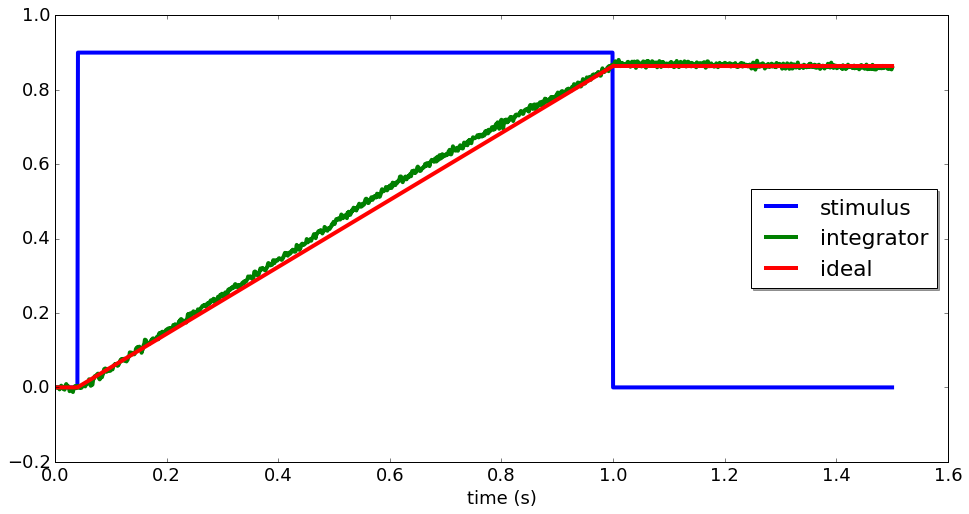

In [29]:
def three_a():

	stim_function = lambda t: 0.9*(0.04<t<1.0)
	neuron_type = 'spike'
	three_template(stim_function,neuron_type)
    
three_a()

The expected result (actually a close numerical approximation of it) is plotted in red. This value corresponds to finding the integral of the differential equation describing the value stored in the integrator ensemble over all time. The general form of this differential equation can be written using control theory:

$\dot{x} = Ax + Bu$

where $x$ is the represented state variable, $u$ is the input, $A$ is the feedback matrix, and $B$ is the input matrix. In this case, $x$ and $u$ are one-dimensional, and the integrator merely accumulates the value of its input ($A=0$ as in the eye control example in Lecture 2), so this equation reduces to

$\dot{x} = u =
    \begin{cases}
        0.9 \quad &0.04<t<1.0 \\ 
        0 &\mbox{otherwise} 
    \end{cases}
$

Integrating to find x(t), we get

$x(t) = \int_0^T u dt = 
    \begin{cases}
        0 \quad &T<0.04 \\ 
        \int_{0.04}^{T} 0.9 dt = 0.9(T-0.04) &0.04<T<1.0 \\
        \int_{0.04}^{1.0} 0.9 dt = 0.864 &T>1.0
    \end{cases}
$

The simulation slightly overestimates this value due to the differences between the synaptic time constant of the feedback connection, $\tau_{feedback}$, and the input connection, $\tau_{input}$. When $\tau_{input}$<$\tau_{feedback}$, as above, the stimulus is delivered on a shorter timescale than the recurrent input, leading to rapid accumulation and overestimation during the ramp. Once input is removed, the value stored in the integrator steadily moves towards $ideal=0.864$ (or to the nearest attractor in the neuron space). When the values are equal, the estimation during input is much more accurate; and when $\tau_{input}$>$\tau_{feedback}$, the large degree of smoothing causes less input to be delivered to the integrator than is 'expected' by the reccurent connection, causing underestimation.

[1 mark] Change the neural simulation to rate mode (use `model.config[nengo.Ensemble].neuron_type = nengo.LIFRate()` which will change all neurons in the simulation to LIF rate neurons).  Re-run the simulation in rate mode.  Show the resulting plots.  How does this compare to the result in part (a)?

Simulation finished in 0:00:01.                                                 


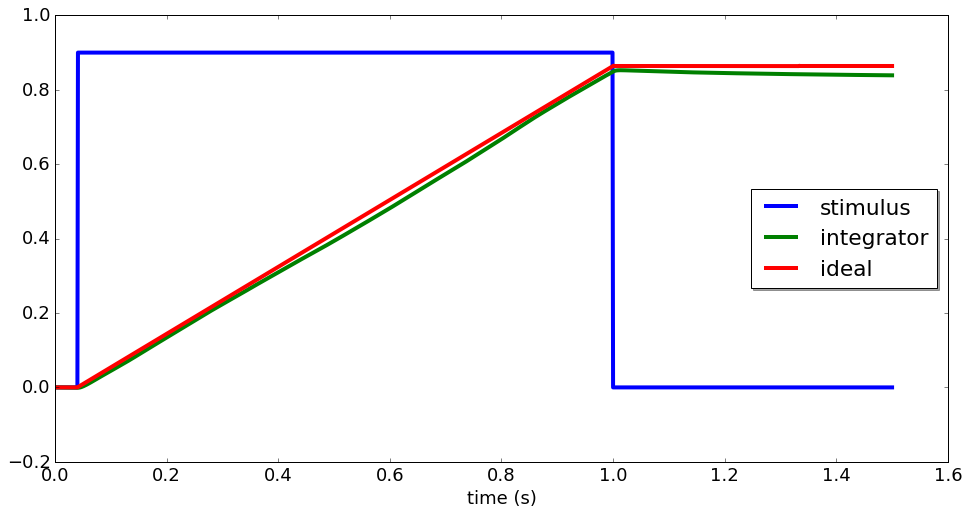

In [30]:
def three_b():

	stim_function = lambda t: 0.9*(0.04<t<1.0)
	neuron_type = 'rate'
	three_template(stim_function,neuron_type)
    
three_b()

The accuracy with a LIFRate() model is slightly improved because noise is averaged by the firing rate calculation.,  Overall, though, the precision is comparable (no significant under- or over-estimation)

[1 mark] Returning to spiking mode, change the input to be a value of 0.9 from t=0.04 to 0.16.  Show the same plots as before (the input and the value represented by the ensemble over 1.5 seconds).  How does this compare to (a)?  Why is it better or worse?

Simulation finished in 0:00:01.                                                 


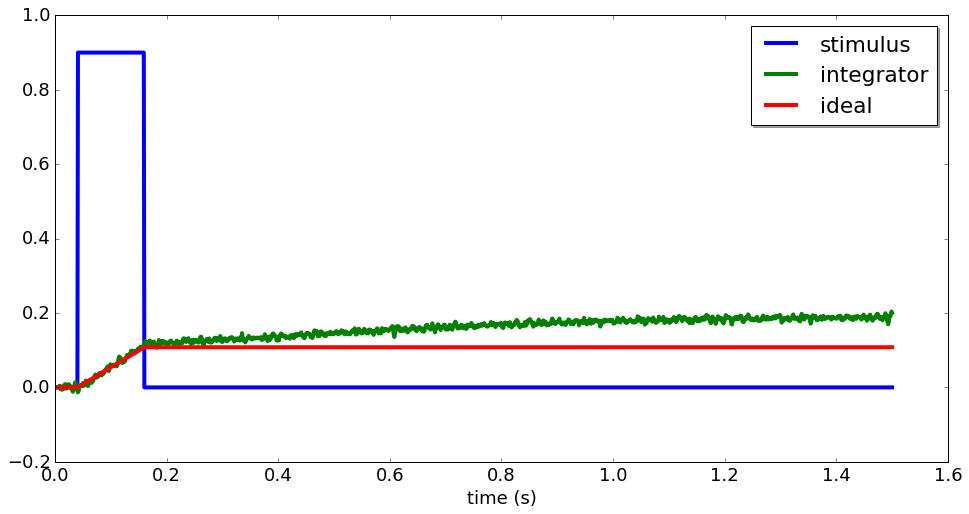

In [31]:
def three_c():

	stim_function = lambda t: 0.9*(0.04<t<0.16)
	neuron_type = 'spike'
	three_template(stim_function,neuron_type)
    
three_c()

The behavior seems similar to (a), except that we see a larger time interval over which the integrator must maintain its value. This highlights the distortion error due to local attractors in the representation, as discussed in Lecture 6. The representation of the value in the integrator lies above and below the ideal value at various times/values (and for various seeds). Every other crossing of $\hat{x}$ with $x$ will produce a stable attractor, to which the representation will converge in the presence of noise. If the stable attractor at the final value of $x(t)$ is above the ideal value of $x(t)$, the estimate $\hat{x}(t)$ will stabilize at this attractor, systematically overestimating the state over time, as can be observed in the figure above.

One other minor difference is the shorter stimulus interval, which limits the amount of noise that can accumulate through the recurrent connection in the integrator, which likely leads to less absolute error by the end of the simulation.

[1 mark] Change the input to a ramp input from 0 to 0.9 from t=0 to t=0.45 (and 0 for t>0.45). Show the same plots as in the previous parts of this question.  What does the ensemble end up representing, and why?  What is the (ideal) equation for the curve traced out by the ensemble?

Simulation finished in 0:00:01.                                                 


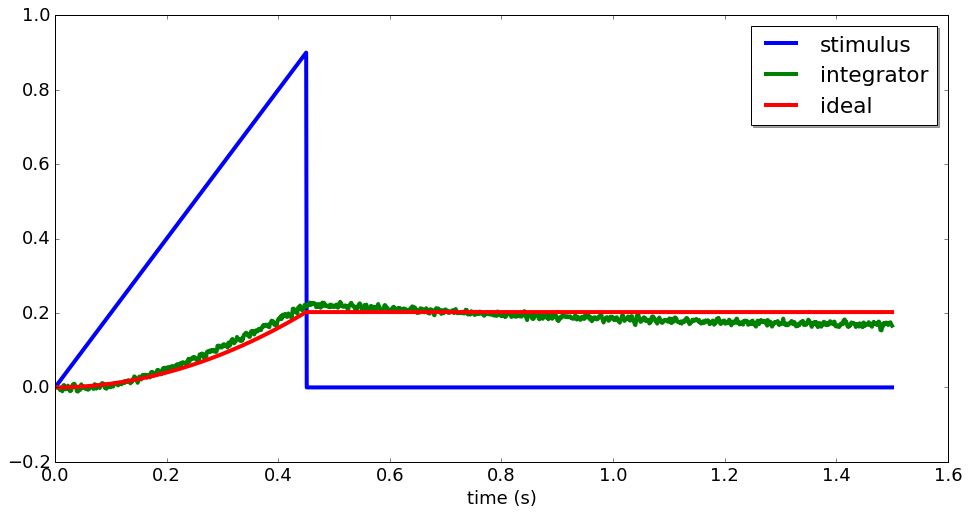

In [34]:
def three_d():

	stim_function = lambda t: 2.0*t*(0.0<=t<=0.45)
	neuron_type = 'spike'
	three_template(stim_function,neuron_type)

three_d()

The ideal equation for the integrator to represent is

$\dot{x} = u =
    \begin{cases}
        \int_{0}^{T} 2t dt = T^2 &0.<T<0.45 \\
        \int_{0}^{0.45} 2t dt = 0.2025 &T>0.45
    \end{cases}
$

The ensemble represents the ideal value fairly accurately, given noise and limited number of neurons.

[1 mark] Change the input to $u=5sin(5t)$.  What should the value represented by the ensemble be (write the equation)?  How well does it do?  What are the differences between the model's behaviour and the expected ideal behaviour?

Simulation finished in 0:00:01.                                                 


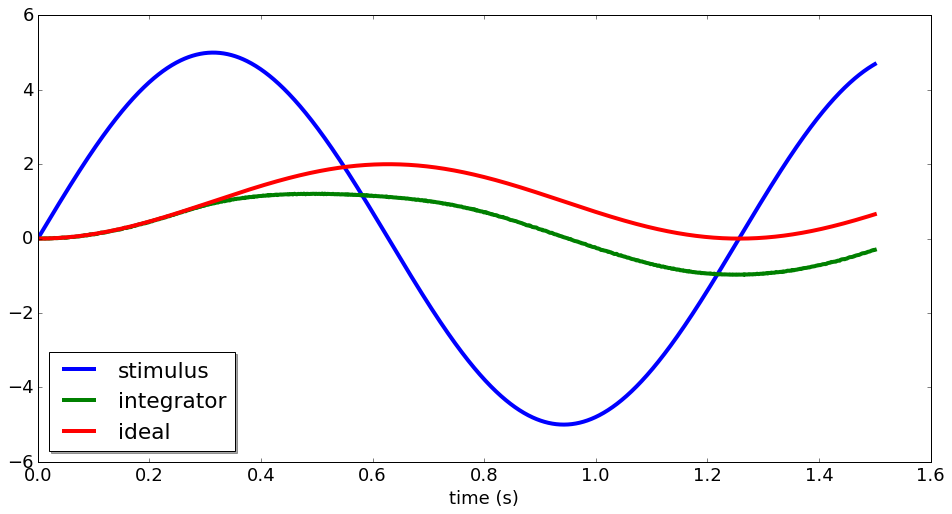

In [35]:
def three_e():

	stim_function = lambda t: 5.0*np.sin(5.0*t)
	neuron_type = 'spike'
	three_template(stim_function,neuron_type)
    
three_e()

The ideal equation for the integrator to represent is

$\dot{x} = u = \int_{0}^{T} 5sin(5t) dt  = 1-cos(5T)$

The model does poorly in this case: it significantly underestimates the ideal value for $t>0.4$. In fact, it seems that the estimate follows the curve $\hat{x}(t)=-cos(5t)$ instead of $\hat{x}(t)=1-cos(5t)$. We obtained the value $1$ from stipulating the initial condition $x(0)=0$, which seems reasonable given that the neural activity begins at rest. However, while this ideal function is well approximated by the estimate initially, it seems the estimate to converges $\hat{x}(t)=-cos(5t)$ as $t$ increases. This discrepancy disappears either when the stimulus is phase shifted by $\pi/2$ or the radius of the ensemble is increased.

These problems indicate that neurons are saturating when trying to reproduce the integrated sinusoid: when the ideal curve varies between -1 and 1 (as it does in the shifted case), the estimate is exact; and when the radius is increased, they can represent values from 0 to 2. The reason that the estimate appeared to represent the curve $-cos(5t)$ is that it saturated when the ideal curve reached a value around 1, then decreased by a value of 2 during the downswing of the ideal curve, producing a sinusoid the varies between -1 and 1.

Simulation finished in 0:00:01.                                                 


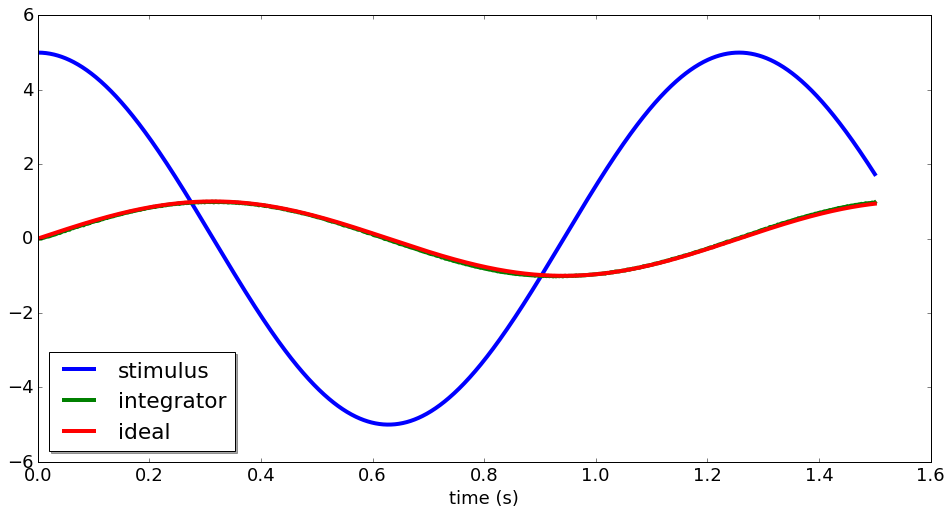

In [36]:
def three_e():

	stim_function = lambda t: 5.0*np.sin(5.0*(t+np.pi/2))
	neuron_type = 'spike'
	three_template(stim_function,neuron_type)
    
three_e()

[Bonus, up to 2 marks] Implement a nonlinear dynamical system we have not seen in class, and demonstrate that it's working as expected.

Let's try making a double pendulum, borrowing differential equations from http://matplotlib.org/examples/animation/double_pendulum_animated.html

Simulation finished in 0:00:08.                                                 


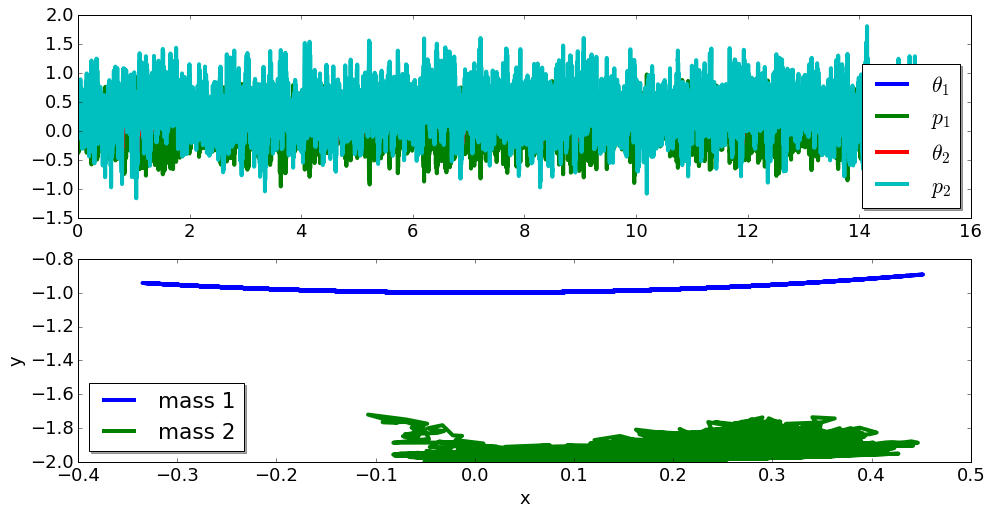

In [38]:
def three_bonus():

#ensemble parameters
	N=2000
	dimensions=4
	tau_rc=0.02
	tau_ref=0.002
	tau=0.02
	noise=0.001
	T=15.0
	seed=3

	#pendulum parameters
	G = 9.8  # acceleration due to gravity, in m/s^2
	L1 = 1.0  # length of pendulum 1 in m
	L2 = 1.0  # length of pendulum 2 in m
	M1 = 1.0  # mass of pendulum 1 in kg
	M2 = 1.0  # mass of pendulum 2 in kg
    
	# th1 and th2 are the initial angles (degrees)
	# w10 and w20 are the initial angular velocities (degrees per second)
	th1 = 120.0
	w1 = 0.0
	th2 = -10.0
	w2 = 0.0
	t_stim=0.1

	# initial state to push the neurons towards
	state_init = np.radians([th1, w1, th2, w2])
    
	# normal spiking LIF neurons
	lif_model=nengo.LIF(tau_rc=tau_rc,tau_ref=tau_ref)

	model=nengo.Network(label='Double Pendulum')

	with model:

		#push the model into the initial state using stimulus noes
		stimulus_2=nengo.Node(output=lambda t: state_init[1]*(0<t<t_stim))
		stimulus_3=nengo.Node(output=lambda t: state_init[2]*(0<t<t_stim))
		stimulus_4=nengo.Node(output=lambda t: state_init[3]*(0<t<t_stim))
		stimulus_1=nengo.Node(output=lambda t: state_init[0]*(0<t<t_stim))
        
		#create the ensemble
		ens1 = nengo.Ensemble(N,dimensions,
									intercepts=Uniform(-1.0*2.0*np.pi,1.0*2.0*np.pi),
									max_rates=Uniform(100,200),
									neuron_type=lif_model)

		#define recurrent transformation
		def recurrent(state):

			dydx = np.zeros_like(state)
			dydx[0] = state[1]

			del_ = state[2] - state[0]
			den1 = (M1 + M2)*L1 - M2*L1*np.cos(del_)*np.cos(del_)
			dydx[1] = (M2*L1*state[1]*state[1]*np.sin(del_)*np.cos(del_) +
				M2*G*np.sin(state[2])*np.cos(del_) +
				M2*L2*state[3]*state[3]*np.sin(del_) -
				(M1 + M2)*G*np.sin(state[0]))/den1

			dydx[2] = state[3]

			den2 = (L2/L1)*den1
			dydx[3] = (-M2*L2*state[3]*state[3]*np.sin(del_)*np.cos(del_) +
				(M1 + M2)*G*np.sin(state[0])*np.cos(del_) -
				(M1 + M2)*L1*state[1]*state[1]*np.sin(del_) -
				(M1 + M2)*G*np.sin(state[2]))/den2

			return dydx

		#stimulate the ensemble
		stim1=nengo.Connection(stimulus_1,ens1[0],transform=tau,synapse=tau)
		stim2=nengo.Connection(stimulus_2,ens1[1],transform=tau,synapse=tau)
		stim3=nengo.Connection(stimulus_3,ens1[2],transform=tau,synapse=tau)
		stim4=nengo.Connection(stimulus_4,ens1[3],transform=tau,synapse=tau)

		#create recurrent connection
		channel=nengo.Connection(ens1,ens1,
									function=recurrent,
									synapse=tau,  
									solver=LstsqNoise(noise=noise))

		#le probing man
		probe_pendulum=nengo.Probe(ens1,synapse=tau)

	#run the model
	sim=nengo.Simulator(model,seed=seed)
	sim.run(T)

	data=sim.data[probe_pendulum]

	theta1=data[:,0]
	p1=data[:,1]
	theta2=data[:,2]
	p2=data[:,3]

	#transform into x-y coordinates of the respective masses
	x1 = L1*np.sin(data[:, 0])
	y1 = -L1*np.cos(data[:, 0])
	x2 = L2*np.sin(data[:, 2]) + x1
	y2 = -L2*np.cos(data[:, 2]) + y1

	#debugging
	# print theta1

	#plot input and integrator value
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(211)
	ax.plot(sim.trange(),theta1,label='$\\theta_1$')
	ax.plot(sim.trange(),p1,label='$p_1$')
	ax.plot(sim.trange(),theta2,label='$\\theta_2$')
	ax.plot(sim.trange(),p2,label='$p_2$')
	legend=ax.legend(loc='best',shadow=True)
	ax=fig.add_subplot(212)
	ax.plot(x1,y1,label='mass 1')
	ax.plot(x2,y2,label='mass 2')
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	# ax.set_ylim(0,1)
	legend=ax.legend(loc='best',shadow=True)
	plt.show()
    
three_bonus()

This is totally wrong. Turns out it's difficult to implement a nonlinear system, because you can't just define an $A$ matrix for a recurrent connection! This almost worked in this case, but the $sin$ and $cos$ terms in the derivative equations make a linear solution impossible. I looked in the NEF book and the notes, but couldn't find any examples of nonlinear systems which did anything except multiply, so I'm at a loss for how to how to combine multiple states into a single population in a manner that would allow these nonlinear operations. I could try a Taylor Approximation for these expresesions, but with only the first derivative available, the linear range of these approximations would be much smaller than the ranges necessary to simulate the system. 